## **0. Introduction**

This notebook follows after the "General Linear Model.iypnb" notebook. Aim of this notebook is to conduct the logistic regression algorithm. For now, we have 26 z-maps, so one for each contrast, for each session, per run i.e. 4 * 5 * 26 z-maps.

## **1. Masking**

First we will need to load the mask. The masks needs to be fetched from the openneuro dataset. This is done with *datalad*.

We cd into the local dataset directory and then use the command:

datalad get sourcedata/sub-01/anat.

The masks are bi-lateral organised, meaning one mask per hemisphere. For starters, ventral portion of the v1 cortex in the left hemisphere (LH_V1v) will be the first mask.

In [1]:
import os

os.chdir("/home/jpauli/ds001506/sourcedata/sub-01/anat")
os.listdir()

['sub-01_mask_LH_FFA.nii.gz',
 'sub-01_mask_LH_hV4.nii.gz',
 'sub-01_mask_LH_HVC.nii.gz',
 'sub-01_mask_LH_LOC.nii.gz',
 'sub-01_mask_LH_PPA.nii.gz',
 'sub-01_mask_LH_V1d.nii.gz',
 'sub-01_mask_LH_V1v.nii.gz',
 'sub-01_mask_LH_V2d.nii.gz',
 'sub-01_mask_LH_V2v.nii.gz',
 'sub-01_mask_LH_V3d.nii.gz',
 'sub-01_mask_LH_V3v.nii.gz',
 'sub-01_mask_RH_FFA.nii.gz',
 'sub-01_mask_RH_hV4.nii.gz',
 'sub-01_mask_RH_HVC.nii.gz',
 'sub-01_mask_RH_LOC.nii.gz',
 'sub-01_mask_RH_PPA.nii.gz',
 'sub-01_mask_RH_V1d.nii.gz',
 'sub-01_mask_RH_V1v.nii.gz',
 'sub-01_mask_RH_V2d.nii.gz',
 'sub-01_mask_RH_V2v.nii.gz',
 'sub-01_mask_RH_V3d.nii.gz',
 'sub-01_mask_RH_V3v.nii.gz']

In [2]:
len(os.listdir())

22

We can see that there are 22 masks in total, 11 for each hemisphere. 

In [3]:
mask_img_path = '/home/jpauli/ds001506/sourcedata/sub-01/anat'
mask_img_L = os.path.join(mask_img_path,'sub-01_mask_LH_V1v.nii.gz')

As mentioned before in the literature review part, The V1 seems to be a suitable canidate for mental imagery. Thus, we will choose this region as our mask.

In [4]:
func_filename_path = '/mnt/c/Users/janos/git/sessions_new/z_maps_1_perrun'
func_filename =  os.path.join(func_filename_path,'01_active -1443537.0_1_z_map.nii.gz')

/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/numpy/ma/core.py:2830: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


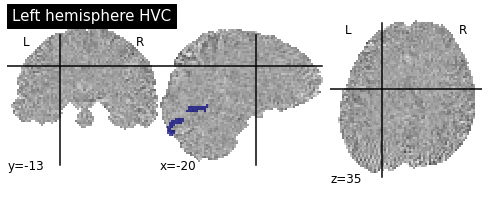

In [5]:
coordinates_func = (-20,-13,35)
from nilearn.plotting import plot_roi
plot_roi(mask_img_L, func_filename,display_mode='ortho',cut_coords=coordinates_func,
         title="Left hemisphere HVC")

Now the next step is to load in the X and Y variables. We will do this by applying Nilearns Niftimasker function on the z_maps we calculated.

In [6]:
from nilearn.maskers import NiftiMasker
nifti_masker = NiftiMasker(mask_img=mask_img_L)

This loops helps us in extracting the time series from each z-map.
Also, we append values to the y list. We have 26 different categories we want to decode. Since there are 4 sessions in total and the categories are the same for each session, we will add a "1" for category one and so on to the Y list.

Since there are 5 runs per category, we also need to define a category starting index and a boundary index. This way we can keep track of which zmaps belongs to which image category.

In [7]:
X = []
y = []
Sessions = []
category = 1
cat_index = 0
cat_index_boundary = 5
for session in ["1","2","3","4"]:
    os.chdir('/mnt/c/Users/janos/git/sessions_new/z_maps_{}_perrun'.format(session))
    for x in os.listdir():
        if x == 'nilearn_cache':
            continue
        else:
            X.append(nifti_masker.fit_transform(x))
            y.append(category)
            Sessions.append(session)
            cat_index = cat_index + 1
            if cat_index == cat_index_boundary:
                category=category+1
                cat_index_boundary = cat_index_boundary+5
            if category == 27:
                category = 1
        
            
        
        
        



First we need to transform our list type variables into numpy arrays. Then, we can check the shape of our input (X) and output(y) data.

In [8]:
import numpy as np
y = np.array(y)
y.shape
y.shape

(520,)

In [9]:
import pandas as pd
df =  pd.DataFrame(np.concatenate(X))

In [10]:
X = df.to_numpy()
X.shape

(520, 992)

There are 520 rows for both X and y. This makes sense, because each row represents the respective image category label. The columns in our X data represents the voxels in our specific mask, in other words: We have the activity of 992 voxels per category.

## **2.0 Examing the voxel pattern**

The shape of our input array X tells us, that we have n_samples = 104 and n_features = 992.
The features relate to the amount of voxels extracted. The samples are the 26 categories multiplied by all 4 sessions.

First, we will take a look at the correlation matrix.

Text(0, 0.5, 'Samples')

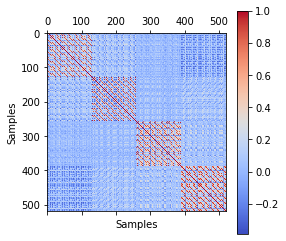

In [11]:
import matplotlib.pyplot as plt
corr =np.corrcoef(X)
plt.matshow(corr, cmap='coolwarm')
plt.colorbar()
plt.xlabel('Samples')
plt.ylabel('Samples')

The correlation matrix tells us, that there are 4 large patterns to detect. The correlation patterns are between each session. This means, that there is a huge correlation within each session, but not between sessions. This could lead to some problems later on. We will first examine the voxel pattern, run the logist regression model and then see, how much the correlation will affect our results.

We now want to examine the voxel pattern for different given categories and sessions. This can help with understanding the data we are dealing with.

In [12]:
X_1 = np.reshape(X[0],(31,32))
X_11 = np.reshape(X[130],(31,32))
X_12 = np.reshape(X[260],(31,32))
X_13 = np.reshape(X[390],(31,32))


X_2 = np.reshape(X[1],(31,32))
X_21 = np.reshape(X[131],(31,32))
X_22 = np.reshape(X[261],(31,32))
X_23 = np.reshape(X[391],(31,32))

X_3 = np.reshape(X[2],(31,32))
X_31 = np.reshape(X[132],(31,32))
X_32 = np.reshape(X[262],(31,32))
X_33 = np.reshape(X[392],(31,32))

X_4 = np.reshape(X[3],(31,32))
X_41 = np.reshape(X[133],(31,32))
X_42 = np.reshape(X[263],(31,32))
X_43 = np.reshape(X[393],(31,32))

Text(0.5, 0.98, 'Voxel pattern for category one for all four sessions for run one')

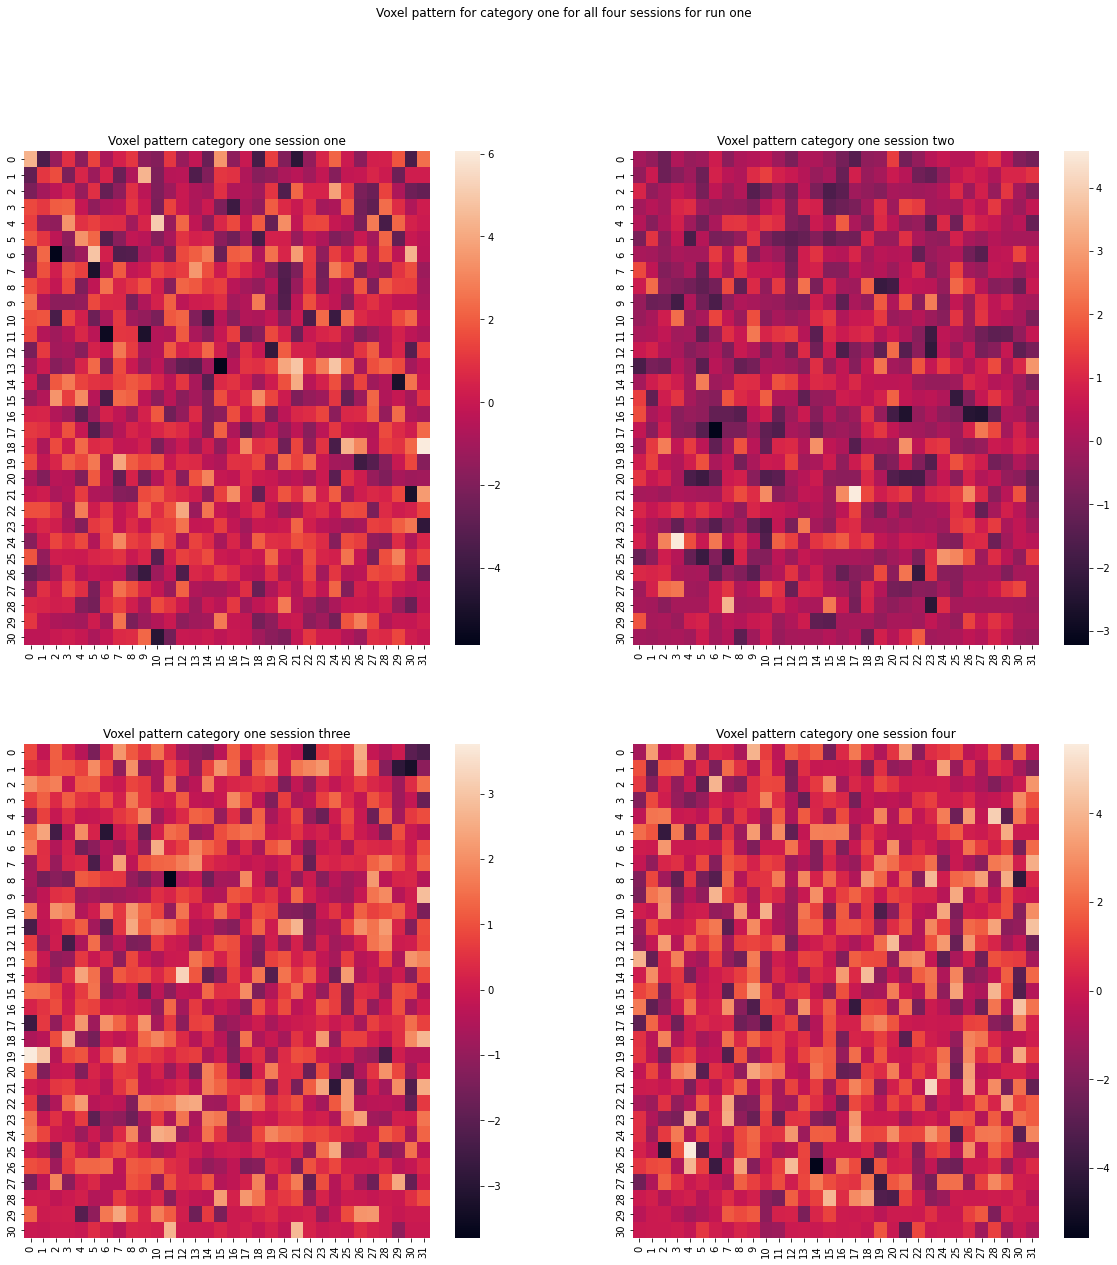

In [13]:
import seaborn as sns
figure, axis = plt.subplots(2, 2,figsize=(20, 20))
im1 = sns.heatmap(X_1,ax=axis[0,0])
im2= sns.heatmap(X_11,ax=axis[0,1])
im3= sns.heatmap(X_12,ax=axis[1,0])
im4= sns.heatmap(X_13, ax=axis[1,1])

#figure.colorbar(orientation='vertical')
axis[0, 0].set_title("Voxel pattern category one session one")
axis[0, 1].set_title("Voxel pattern category one session two")
axis[1, 0].set_title("Voxel pattern category one session three")
axis[1, 1].set_title("Voxel pattern category one session four")

figure.suptitle('Voxel pattern for category one for all four sessions for run one')

Text(0.5, 0.98, 'Voxel pattern for category two for all four sessions for run one')

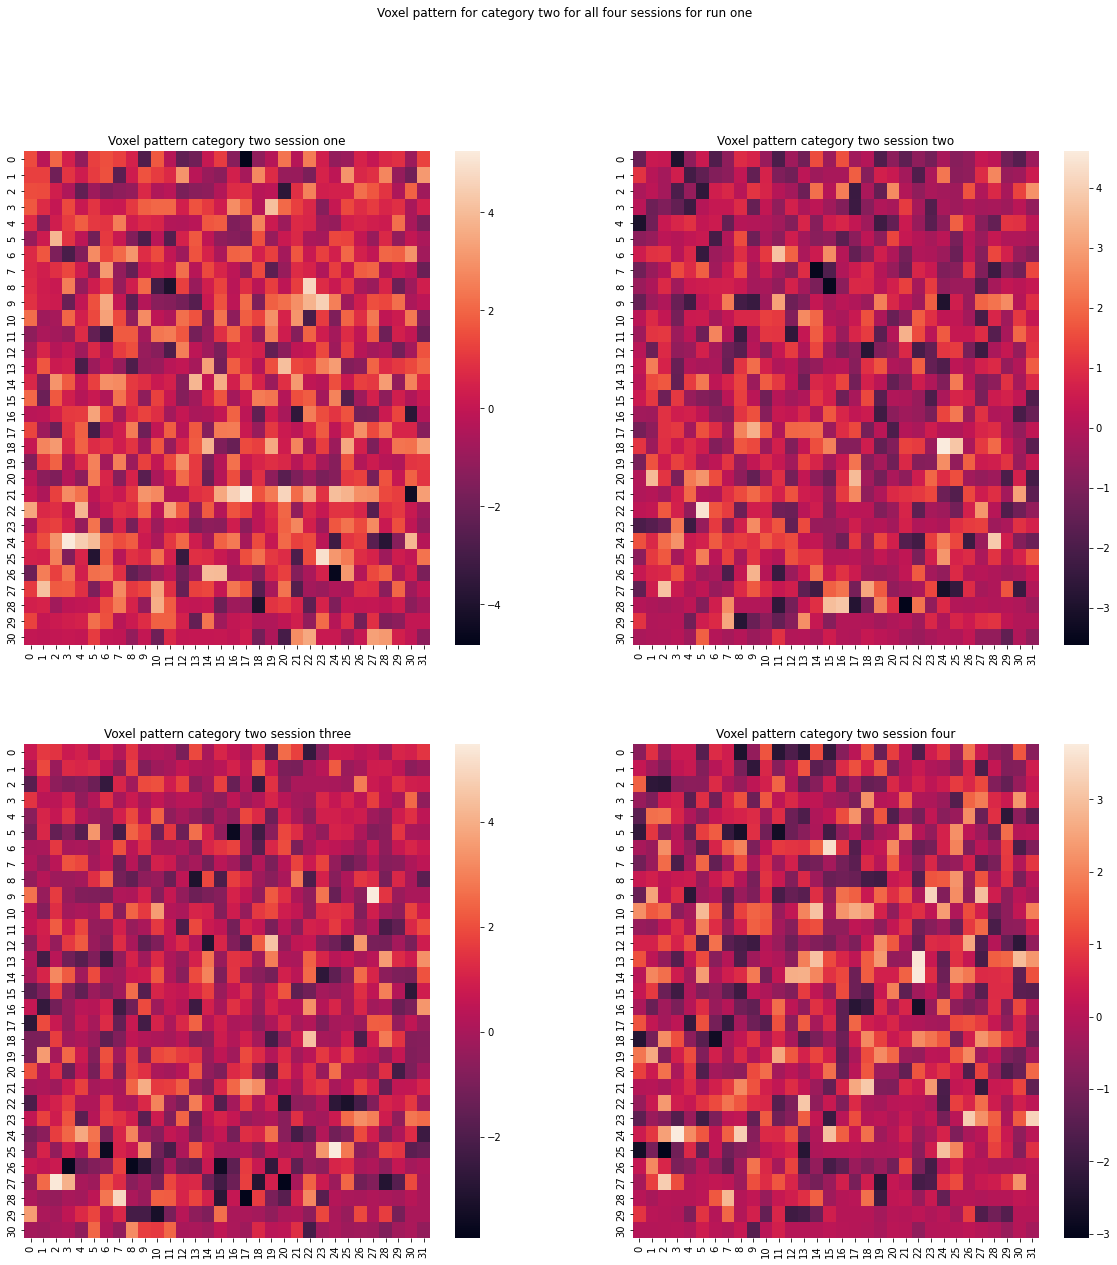

In [14]:
figure, axis = plt.subplots(2, 2,figsize=(20, 20))
im1 = sns.heatmap(X_2,ax=axis[0,0])
im2= sns.heatmap(X_21,ax=axis[0,1])
im3= sns.heatmap(X_22,ax=axis[1,0])
im4= sns.heatmap(X_23, ax=axis[1,1])

#figure.colorbar(orientation='vertical')
axis[0, 0].set_title("Voxel pattern category two session one")
axis[0, 1].set_title("Voxel pattern category two session two")
axis[1, 0].set_title("Voxel pattern category two session three")
axis[1, 1].set_title("Voxel pattern category two session four")

figure.suptitle('Voxel pattern for category two for all four sessions for run one')

Text(0.5, 0.98, 'Voxel pattern for category three for all four sessions for run one')

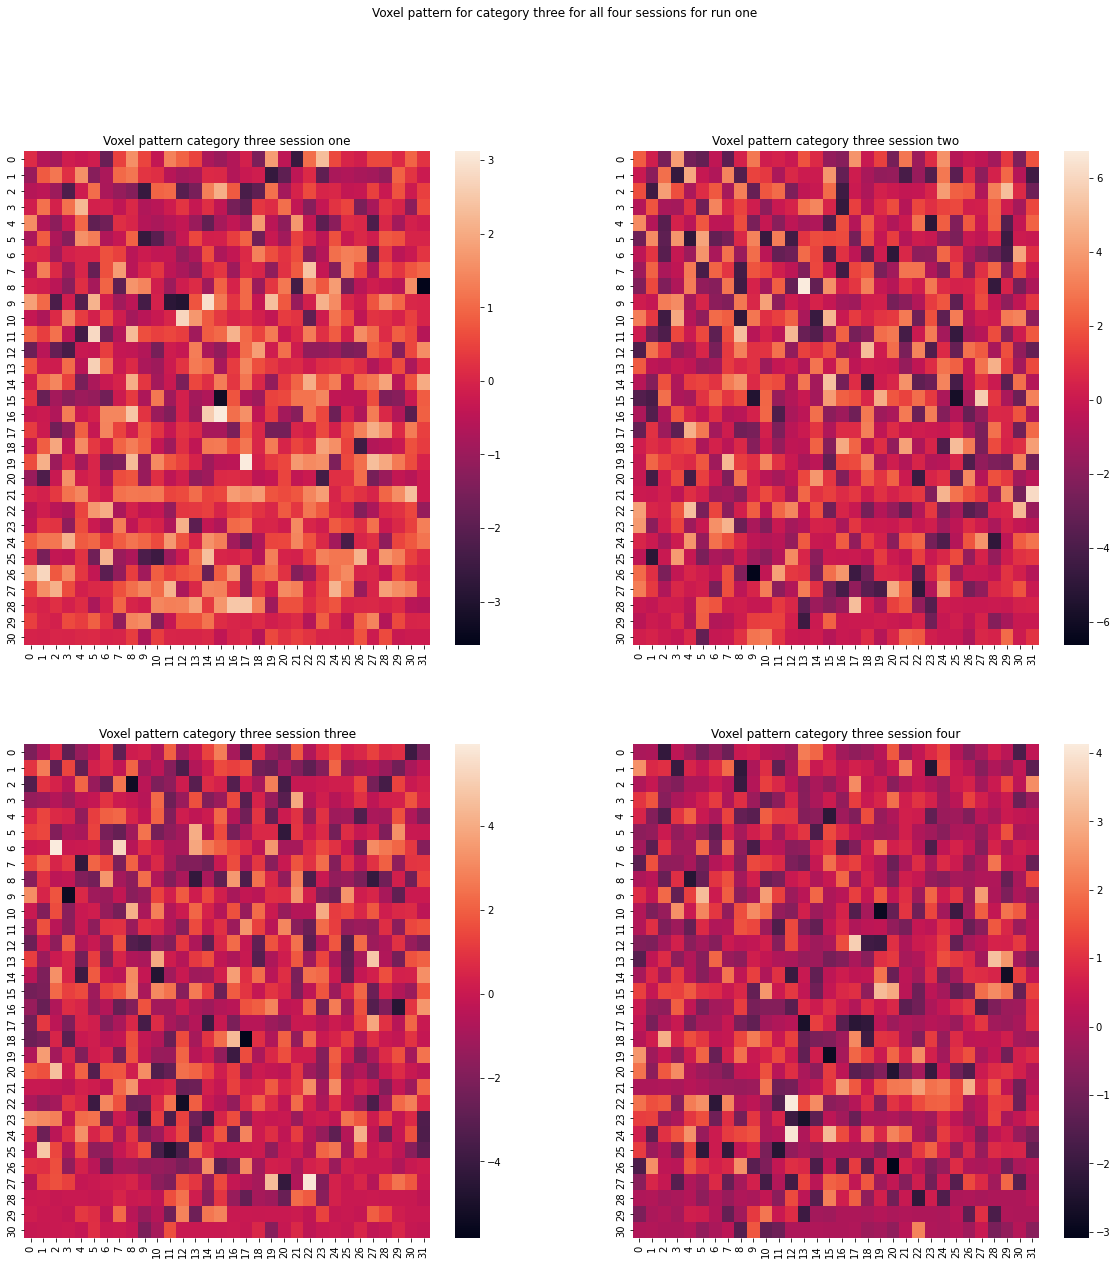

In [15]:
figure, axis = plt.subplots(2, 2,figsize=(20, 20))
im1 = sns.heatmap(X_3,ax=axis[0,0])
im2= sns.heatmap(X_31,ax=axis[0,1])
im3= sns.heatmap(X_32,ax=axis[1,0])
im4= sns.heatmap(X_33, ax=axis[1,1])

#figure.colorbar(orientation='vertical')
axis[0, 0].set_title("Voxel pattern category three session one")
axis[0, 1].set_title("Voxel pattern category three session two")
axis[1, 0].set_title("Voxel pattern category three session three")
axis[1, 1].set_title("Voxel pattern category three session four")

figure.suptitle('Voxel pattern for category three for all four sessions for run one')

Text(0.5, 0.98, 'Voxel pattern for category four for all four sessions for run one')

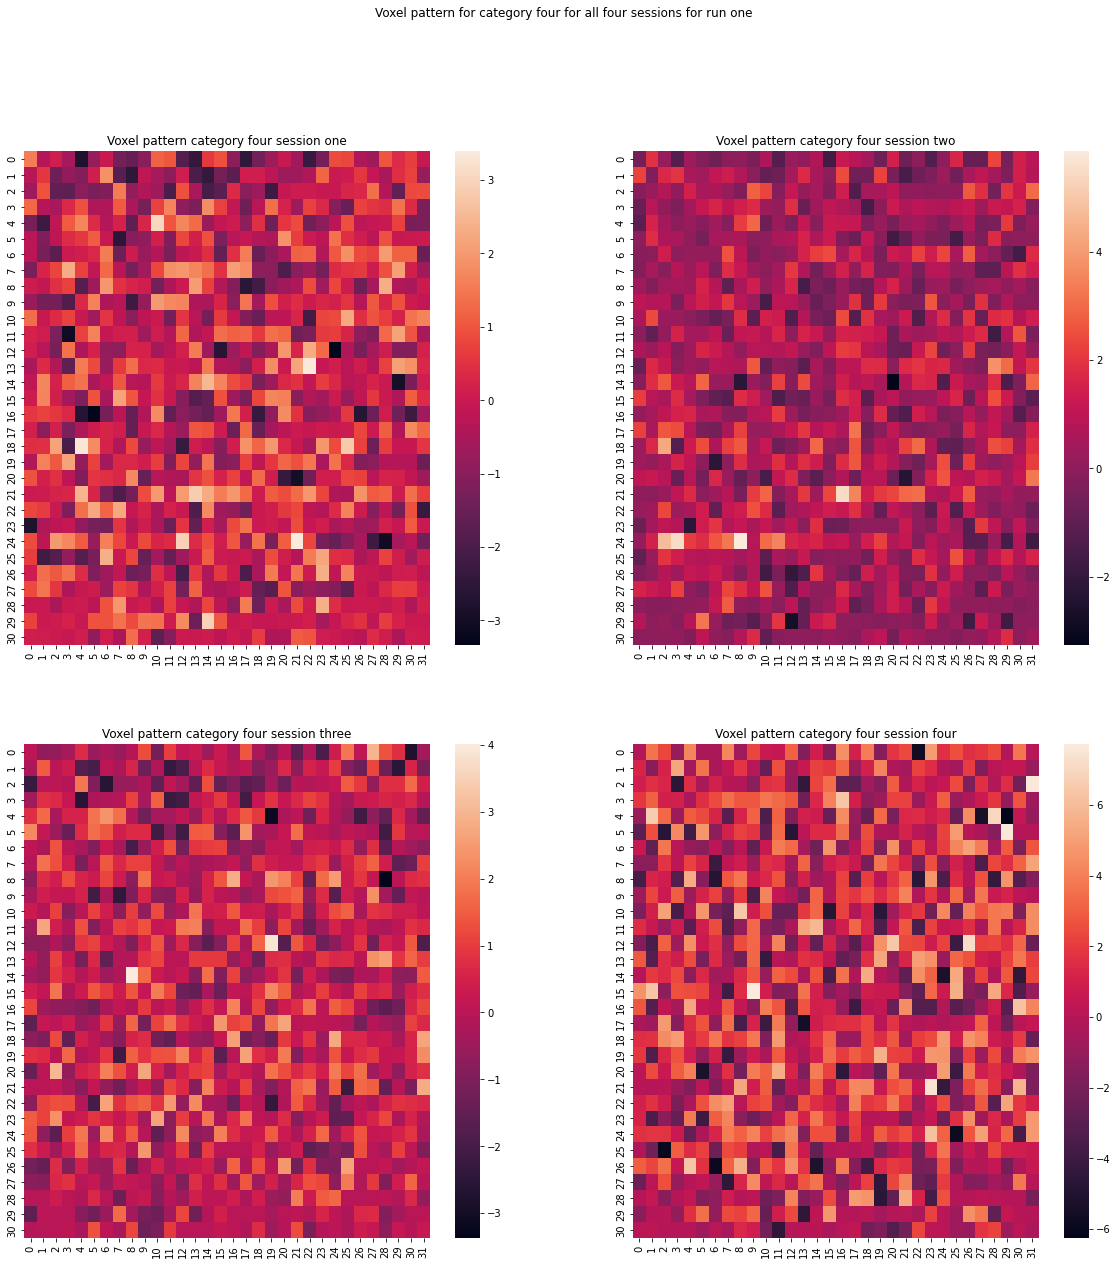

In [16]:
figure, axis = plt.subplots(2, 2,figsize=(20, 20))
im1 = sns.heatmap(X_4,ax=axis[0,0])
im2= sns.heatmap(X_41,ax=axis[0,1])
im3= sns.heatmap(X_42,ax=axis[1,0])
im4= sns.heatmap(X_43, ax=axis[1,1])

#figure.colorbar(orientation='vertical')
axis[0, 0].set_title("Voxel pattern category four session one")
axis[0, 1].set_title("Voxel pattern category four session two")
axis[1, 0].set_title("Voxel pattern category four session three")
axis[1, 1].set_title("Voxel pattern category four session four")

figure.suptitle('Voxel pattern for category four for all four sessions for run one')

Text(0.5, 0.98, 'Voxel pattern for four different categories in session one and run one')

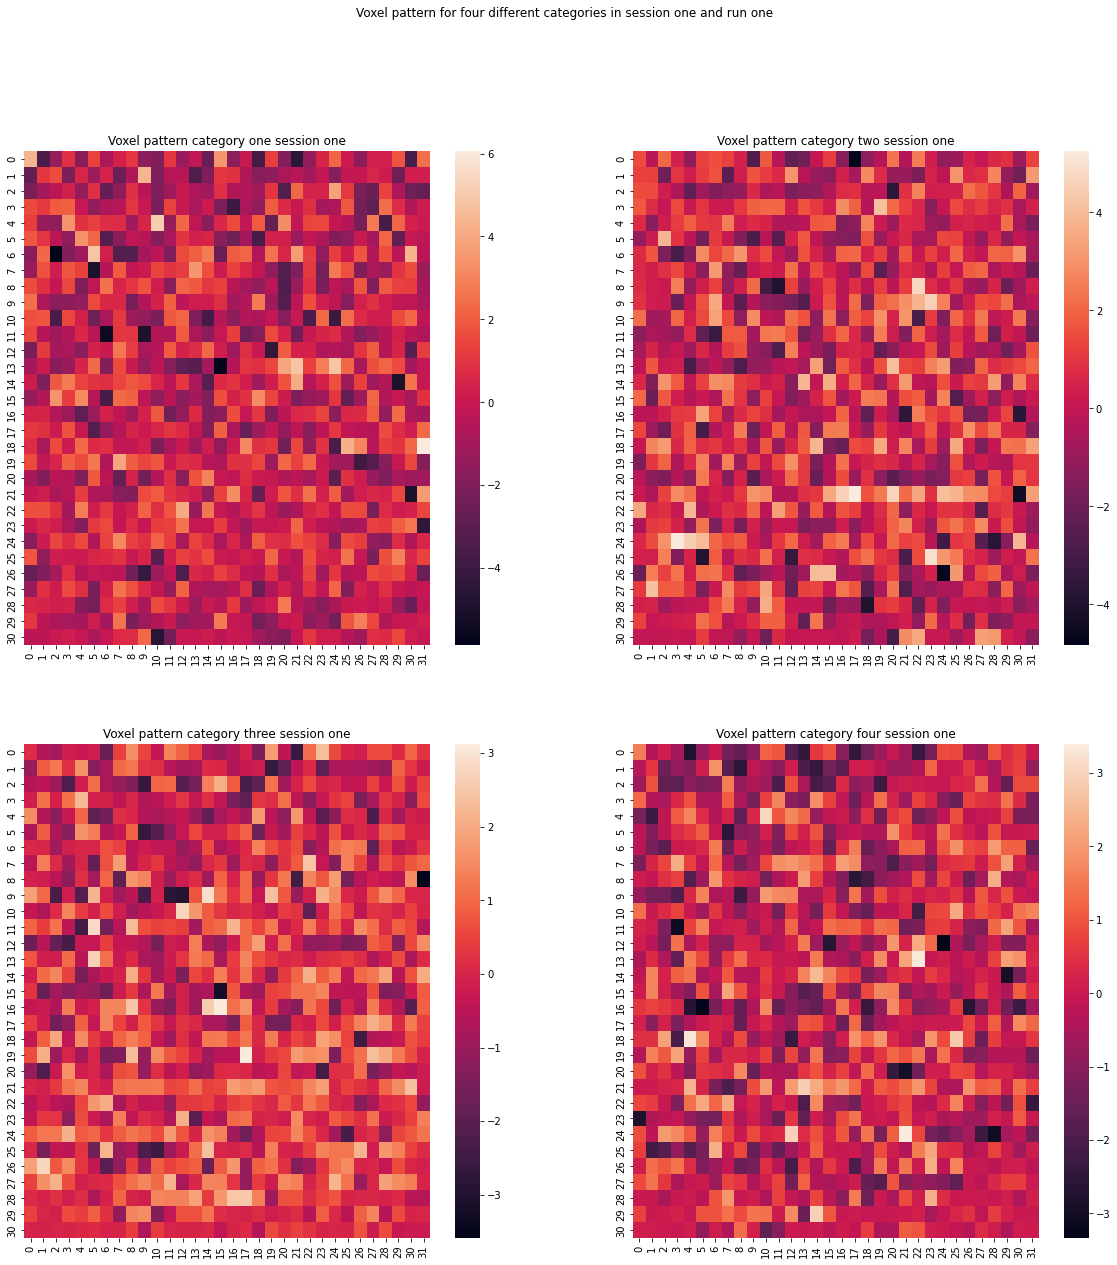

In [17]:
figure, axis = plt.subplots(2, 2,figsize=(20, 20))
im1 = sns.heatmap(X_1,ax=axis[0,0])
im2= sns.heatmap(X_2,ax=axis[0,1])
im3= sns.heatmap(X_3,ax=axis[1,0])
im4= sns.heatmap(X_4, ax=axis[1,1])

#figure.colorbar(orientation='vertical')
axis[0, 0].set_title("Voxel pattern category one session one")
axis[0, 1].set_title("Voxel pattern category two session one")
axis[1, 0].set_title("Voxel pattern category three session one")
axis[1, 1].set_title("Voxel pattern category four session one")

figure.suptitle('Voxel pattern for four different categories in session one and run one')

Text(0.5, 0.98, 'Voxel pattern for four different categories in session two and run one')

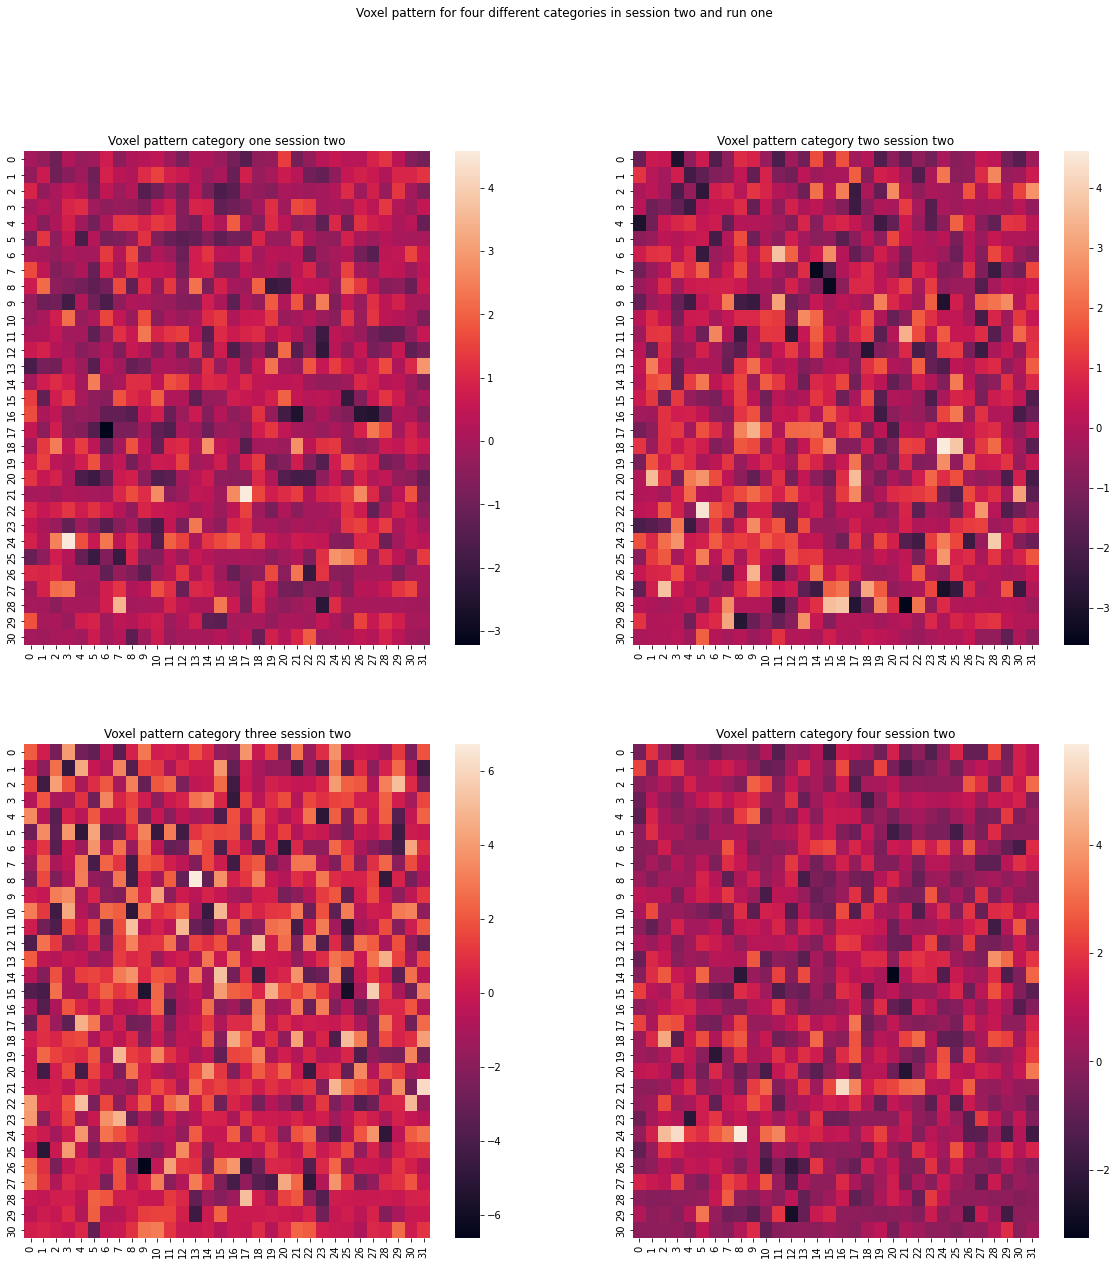

In [18]:
figure, axis = plt.subplots(2, 2,figsize=(20, 20))
im1 = sns.heatmap(X_11,ax=axis[0,0])
im2= sns.heatmap(X_21,ax=axis[0,1])
im3= sns.heatmap(X_31,ax=axis[1,0])
im4= sns.heatmap(X_41, ax=axis[1,1])

#figure.colorbar(orientation='vertical')
axis[0, 0].set_title("Voxel pattern category one session two")
axis[0, 1].set_title("Voxel pattern category two session two")
axis[1, 0].set_title("Voxel pattern category three session two")
axis[1, 1].set_title("Voxel pattern category four session two")

figure.suptitle('Voxel pattern for four different categories in session two and run one')

Text(0.5, 0.98, 'Voxel pattern for four different categories in session three and run one')

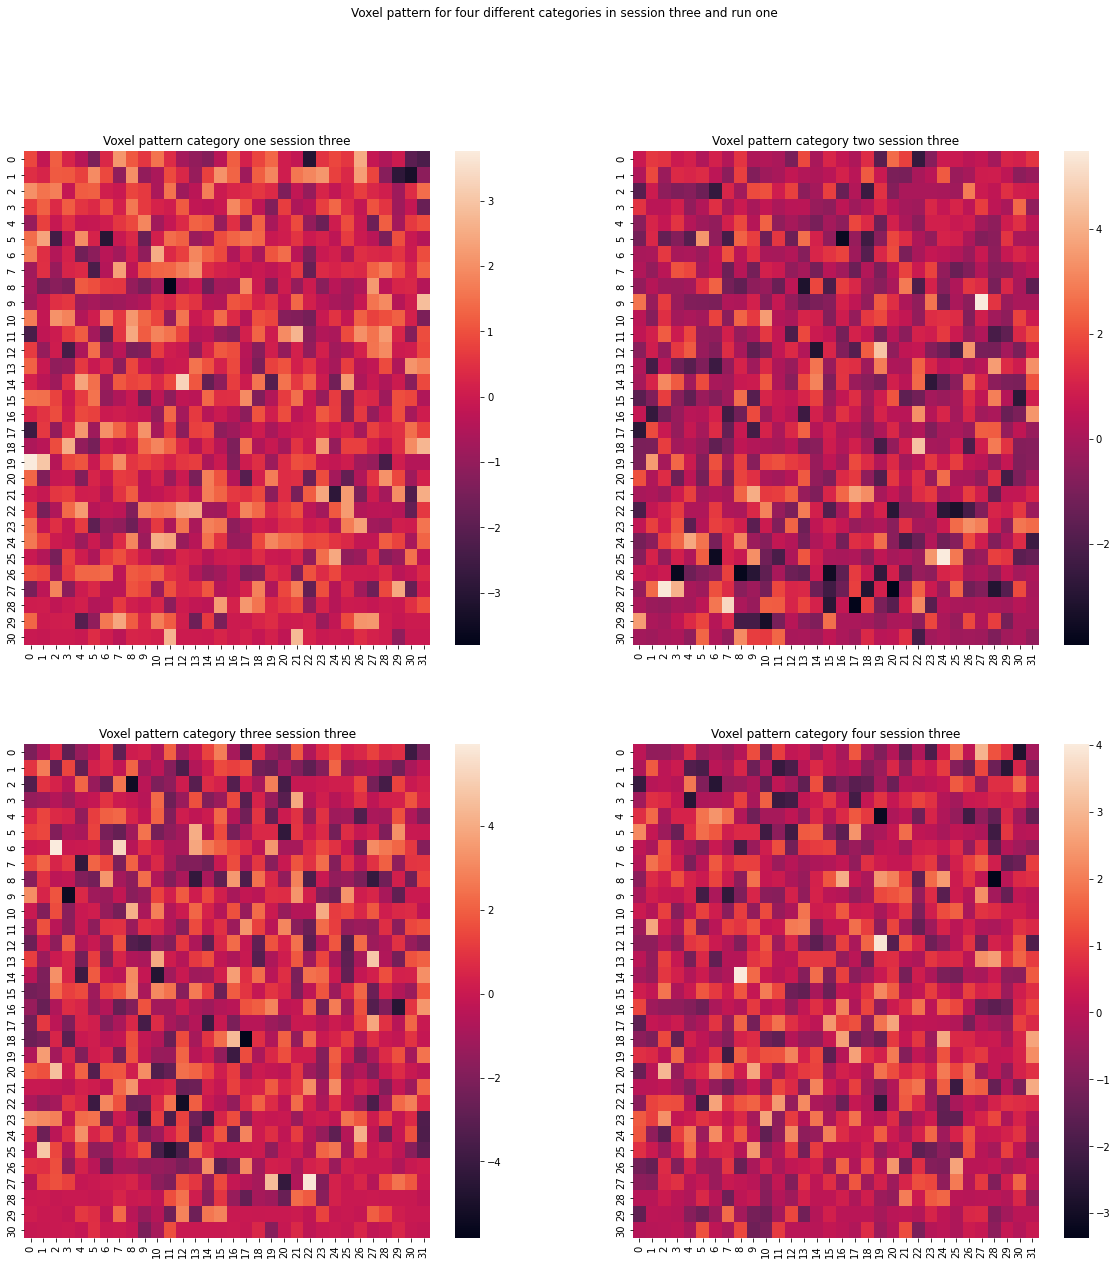

In [19]:
figure, axis = plt.subplots(2, 2,figsize=(20, 20))
im1 = sns.heatmap(X_12,ax=axis[0,0])
im2= sns.heatmap(X_22,ax=axis[0,1])
im3= sns.heatmap(X_32,ax=axis[1,0])
im4= sns.heatmap(X_42, ax=axis[1,1])

#figure.colorbar(orientation='vertical')
axis[0, 0].set_title("Voxel pattern category one session three")
axis[0, 1].set_title("Voxel pattern category two session three")
axis[1, 0].set_title("Voxel pattern category three session three")
axis[1, 1].set_title("Voxel pattern category four session three")

figure.suptitle('Voxel pattern for four different categories in session three and run one')

Text(0.5, 0.98, 'Voxel pattern for four different categories in session four and run one')

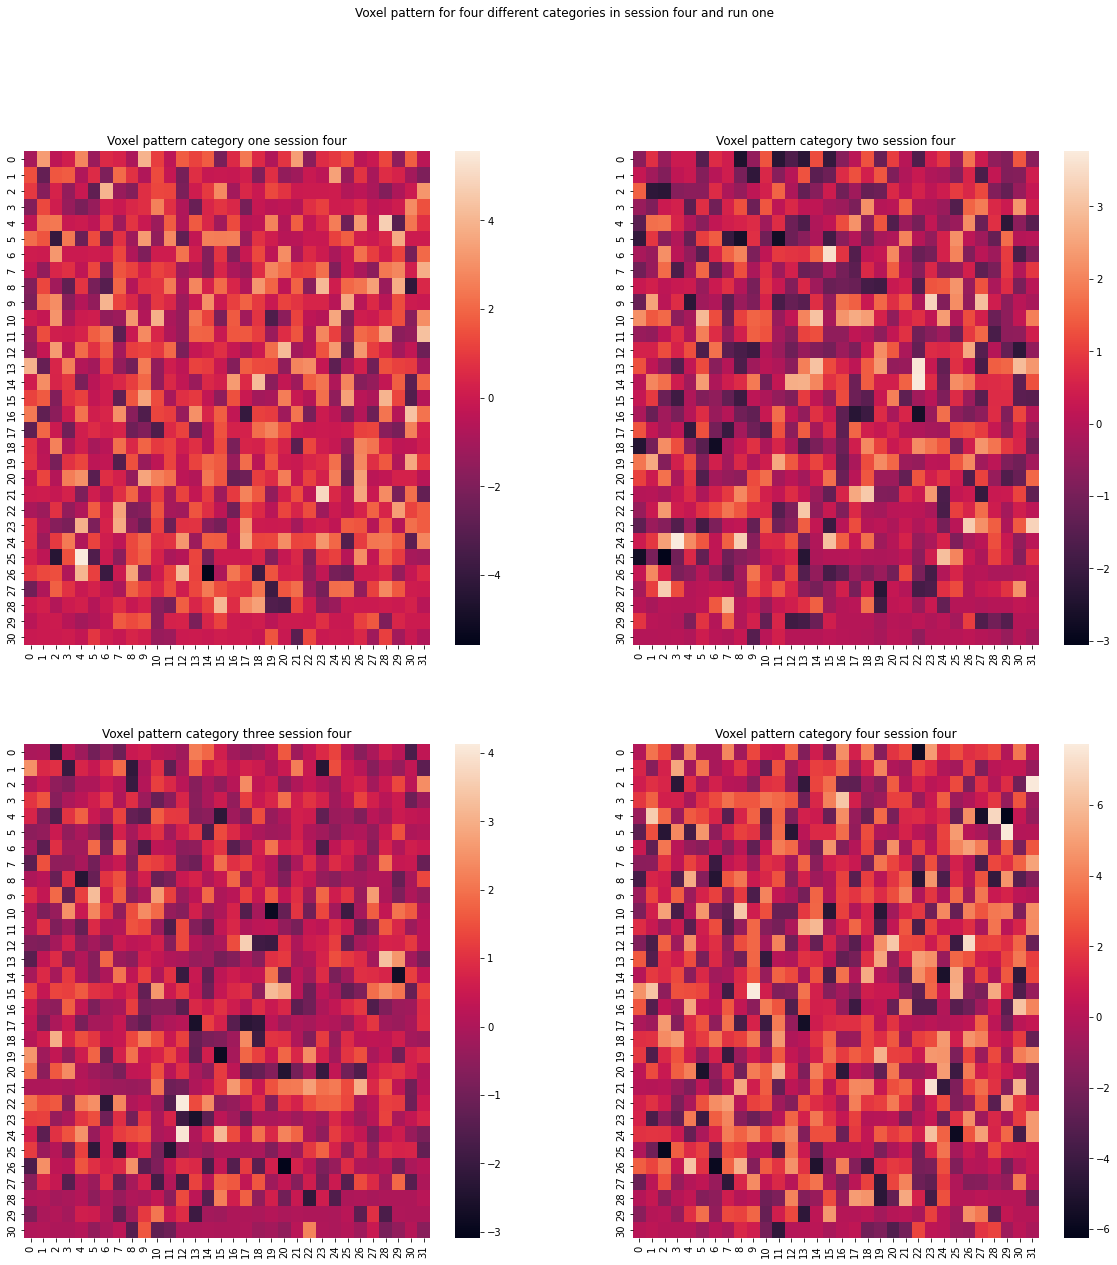

In [20]:
figure, axis = plt.subplots(2, 2,figsize=(20, 20))
im1 = sns.heatmap(X_13,ax=axis[0,0])
im2= sns.heatmap(X_23,ax=axis[0,1])
im3= sns.heatmap(X_33,ax=axis[1,0])
im4= sns.heatmap(X_43, ax=axis[1,1])

#figure.colorbar(orientation='vertical')
axis[0, 0].set_title("Voxel pattern category one session four")
axis[0, 1].set_title("Voxel pattern category two session four")
axis[1, 0].set_title("Voxel pattern category three session four")
axis[1, 1].set_title("Voxel pattern category four session four")

figure.suptitle('Voxel pattern for four different categories in session four and run one')

It really seems like there is no clear pattern to be examined between or within sessions. It rather looks like a lot of noise.

## **3.0 Logistic regression**

<div class="alert alert-block alert-danger">
VERY IMPORANT INFORMATION:

This notebook has been gone through several attempts. Please take a look at the respective github repository folder to understand the different attempts made.

For example: The first idea was to run the Logistic Regression for the z maps across runs. This ended up in really bad results. Different approaches were implemented to defy those bad results, but in the end, it did not matter at all. Thus the last approach, the cross validation strategy "Leave one Group out" is presented in this notebook. If you are interested in the other approaches, please take either a look at the open-lab-notebook, the different github versions or contact me.  </div>

To set up the logistic regression we will mostly use the fantastic machine learning library [sklearn](https://scikit-learn.org/stable/).

We will choose the [leave one group out](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html) method for cross validation. Since we have 4 sessions, we will leave the last session, so session 4, out for testing our data. In the meanwhile, session 1,2 and 3 are cross validated against each other. Meaning, that the logistic regression is trained with the data of session 1 and 2 and then validated against session 3, and so on. This trained model will then be tested on the data from session 4.

But step by step:
1. Define our group variable, which basically just consists of the respective session label for each sample. This is a neccesary argument for the LeaveOneGroupOut method. 
2. Split the data in a training testing set. Then, we are also going to normalize our X data with sklearns *processing* module. In order to do so, we will fit_transform the scaler on to the training data. The scaler has to be solely fitted on to the test data later on.

In [21]:
y_ses = np.array(Sessions)
y_ses.shape

(520,)

In [22]:
groups = y_ses[0:390]

In [30]:
groups

array(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
       '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
       '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
       '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2

In [23]:
X_train = X[0:390]
y_train = y[0:390]

X_test = X[390:520] #leaving session 4 out
y_test = y[390:520]

In [24]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)

In [25]:
X_train

array([[ 2.64917891, -2.64553965, -0.99305767, ...,  1.36191438,
         2.75607907, -0.08791735],
       [ 0.77844309,  0.10000231,  1.80385961, ...,  0.17967888,
         0.03273082, -2.62331056],
       [-0.06570151, -0.21416028, -0.56115439, ..., -0.53804601,
        -1.51282094, -0.40462765],
       ...,
       [-1.33283106, -0.63989117,  0.67598363, ...,  0.45854829,
        -0.24723161, -0.67767179],
       [-0.14811615, -0.22006141, -0.01764536, ...,  0.23074111,
        -1.11073331,  0.72772915],
       [-0.4429714 , -0.62463423, -0.64368391, ..., -0.54341624,
         0.75573819,  0.22432805]])

Step one is finished. We split our X and y variables into a training and testing set, and normalised our X_train variable.

**NOTE**:
The index for the training and testing set are choosen that way, because the first 390 samples belong to session 1 - 3. Remember: One session has 5 runs per 26 categories. Leaving us with 130 samples per session.

Step 3. Import sklearns LeaveOneGroupOut module. Store the method in a variable 'LOGO'. Run a loop over our training variables to get an idea, how the method works "behind the scene":
    

In [26]:
from sklearn.model_selection import LeaveOneGroupOut

LOGO = LeaveOneGroupOut()

In [27]:
train_i = []
test_i = []

In [29]:
for i, (train_index, test_index) in enumerate(LOGO.split(X_train,y_train,groups)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}, group={groups[train_index]}")
    print(f"  Test:  index={test_index}, group={groups[test_index]}")
    train_i.append(train_index)
    test_i.append(test_index)



Fold 0:
  Train: index=[130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255
 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273
 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291
 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309
 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327
 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345
 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363
 364 365 366 367 368 369 370

We now have an idea of how the LOGO method works.
it is time to setup our Logistic Regression model. We will define and then fit it on the training data. Afterwards, we will take a look on how well it can predict the test data.

For this part we need sklearns LogisticRegression function. This method allows us to set up the 'one versus rest (ovr)' multi_class classification algorithm. OVR allows us to compare one class (for example image category one) vs all the other classes. So one model is created for each class. Each model predicts a probability for a given class. The highest probability is then used as a predictor.

In [74]:
cv=LeaveOneGroupOut().split(X_train, y_train, groups)
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=1,multi_class='ovr', penalty = 'l1', solver = 'liblinear')

In [50]:
from sklearn.model_selection import cross_val_score
cross_val_score(model,X_train,y_train,cv=cv)

array([0.02307692, 0.03846154, 0.03846154])

So those cross validation scores, generated by using sklearns 'cross_val_score' method gives us three accuracy scores. Each score represents how well the model could predict the labels based on the LOGO method. So score # 1 is how well the model predicts the labels in session one, when trained on session two and three. Score # 2 based on training the data with session one and three and testing on two, and Score # 3 training the data with session one and two and tested on session three.

Overall the scores are.... very bad, meaning very inaccurate. Accuracy is defined as the fraction of correct predicted labels. This basically means, our model could not predict anything at all. Yikes. We will proceed anyway by fitting a LogisticRegression on the training data (still using our LOGO cross validation) and then testing it on session 4. 

In [75]:
from sklearn.linear_model import LogisticRegressionCV
LOGOReg= LogisticRegressionCV(multi_class='ovr', penalty = 'l2', solver = 'liblinear',cv=cv)

In [76]:
LOGOReg.fit(X_train,y_train)

LogisticRegressionCV(cv=<generator object BaseCrossValidator.split at 0x7f485084b048>,
                     multi_class='ovr', solver='liblinear')

In [77]:
LOGOReg.score(X_train,y_train)

1.0

In [78]:
LOGOReg.score(scaler.transform(X_test),y_test)

0.06153846153846154

<div class="alert alert-block alert-danger">
Please notice, that the testing data has also been normalized. </div>

After fitting our model is becomes very obvious, that we could not predict anything at all in the testing data. Our model seems to be dramatically overfitted.

But lets visualize our results. We can create a classification_report and a confusion matrix.


In [79]:
from sklearn.metrics import classification_report
y_train_pred = LOGOReg.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00        15
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        15
          14       1.00      1.00      1.00        15
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        15
          17       1.00      1.00      1.00        15
          18       1.00    

In [81]:
y_test_pred = LOGOReg.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         5
          12       0.20      0.20      0.20         5
          13       0.06      0.60      0.11         5
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00         5
          16       0.00      0.00      0.00         5
          17       0.00      0.00      0.00         5
          18       0.00    

/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Explaination:

**Precision** is the ratio of true positives (tp) / (tp + false positives (fp))

**Recall** is the ratio of tp / (tp + false negatives (fn))

"**The F-beta** score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0."

**Support** refers to the occurrences of the respective class in y_true.

Source: [Sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support)

In [37]:
from sklearn.linear_model import LogisticRegressionCV
log = LogisticRegressionCV(multi_class='ovr', penalty = 'l1', solver = 'liblinear',cv=cv)

In [43]:
log.fit(X_train,y_train,groups=groups)

TypeError: fit() got an unexpected keyword argument 'groups'

In [42]:
y_train.shape

(390,)

In [34]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=1,multi_class='ovr', penalty = 'l1', solver = 'liblinear')

In [35]:
model.fit(X_train_s,y_train)

LogisticRegression(C=1, multi_class='ovr', penalty='l1', solver='liblinear')

In [41]:
model.score(X_train_s, y_train)

1.0

In [37]:
model.predict(X_train_s)

array([ 1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,
        7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11,
       11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14,
       14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17,
       18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21,
       21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24,
       24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,
        5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12,
       12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15,
       15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19,
       19, 19, 19, 19, 20

In [38]:
y_train

array([ 1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,
        7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11,
       11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14,
       14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17,
       18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21,
       21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24,
       24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,
        5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12,
       12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15,
       15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19,
       19, 19, 19, 19, 20

In [39]:
model.predict(scaler.transform(X_test))

array([11, 11, 15,  1, 24, 11, 13, 10,  1, 24, 11,  4, 15,  1, 12, 11, 13,
       15,  1, 24, 11, 13, 10,  1,  9, 11, 13,  9,  1, 24, 11,  4,  9,  1,
       24, 11,  4,  9,  1, 24, 11,  4, 10,  1, 24, 11,  4, 10,  1, 12, 11,
       13,  9,  1, 12, 11, 13, 15,  1, 12, 11,  4, 15,  1, 12, 11, 13, 15,
        1, 12, 11,  4,  9,  1, 12, 11, 13, 16,  1, 12, 11,  4, 15,  1, 25,
       11,  4, 15,  1, 24, 11,  4, 10,  1, 12, 11, 13, 16,  1, 12, 11, 21,
        9, 10, 12, 11,  4,  9,  1, 12, 11, 13, 15,  1, 24, 11, 13,  9,  1,
       24, 11,  4, 15,  1, 26, 11,  4, 16,  1, 12])

In [40]:
y_test

array([ 1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,
        7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11,
       11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14,
       14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17,
       18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21,
       21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24,
       24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26])

This does not look too good. Apparently our training data can be predicted very well, but on the test data the algorithm performs very poor. We can illustrate those results in a confusion matrix.

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_train = model.predict(X_train_s)
cf_matrix_train = confusion_matrix(y_train, y_pred_train)

sns.heatmap(cf_matrix_train, annot = True)

In [ ]:
y_pred = model.predict(scaler.transform(X_test))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)

 Maybe this can be solved with sklearns gridsearch. This way, we can define a grad and the algorithm tells us, which hyperparameters we should choose in order to get the best accuracy.

In [ ]:
from sklearn.model_selection import GridSearchCV
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(multi_class = "ovr", solver='liblinear')
logreg_cv=GridSearchCV(logreg,grid,cv = 2)
logreg_cv.fit(X_train_s,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)
print("test_accuracy:", logreg_cv.score(scaler.transform(X_test), y_test))

This also does not look very good at all. Thus we should continue down another road.

Our y_test tells us, that not every category is even appearing in the test set. Thats why we will split the data ourselves in 25% test and 75% training data. This way, each samples appears in the testset. Of course, this will happen randomly to defy session effects.

In [ ]:
Y_unique = np.unique(Y)
Y_unique

In [ ]:
np.random.shuffle(Y)
y_train = []
y_test = []


for category in Y[0:130]:
        if len(y_test) == len(Y_unique):
            y_train.append(category)
        else:
            y_test.append(category)
            if y_test.count(category) > 1:
                y_test.remove(category)
                y_train.append(category)
                continue
            
                
                
            

In [ ]:
y_test = np.array(y_test)
y_train = np.array(y_train)

In [ ]:
Y[0:130].shape

In [ ]:
y_train.shape

In [ ]:
y_test.shape

In [ ]:
X_new_new = SelectKBest(f_classif, k=10).fit_transform(X_[0:130], Y[0:130])
X_new_new.shape

In [ ]:
X_train, X_test = train_test_split(X_new_new, test_size=0.2, random_state=42)

In [ ]:
X_train_s_new = scaler.fit_transform(X_train)

In [ ]:
model = LogisticRegression(C = 0.1,multi_class='ovr', penalty = 'l1', solver = 'liblinear')

In [ ]:
model.fit(X_train_s_new,y_train)

In [ ]:
X_train_s_new.shape

In [ ]:
model.score(scaler.transform(X_test), y_test)

In [ ]:
model.score(X_train_s_new,y_train)

In [ ]:
model.predict(X_train_s_new)

In [ ]:
y_train

The model still performs really poor. So this could not solve the problem.

In [ ]:
y_pred_train = model.predict(X_train_s_new)
cf_matrix_train = confusion_matrix(y_train, y_pred_train)

sns.heatmap(cf_matrix_train, annot = True)

In [ ]:
y_pred = model.predict(scaler.transform(X_test))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)

Maybe the split was correct, but we did not manage to choose the right hyperparameters. Thus, sklearns gridsearch will be applied again. Also, we feature selection will be used. More precisely, sklearns *k-best* algorithm. This algorithm helps us in choosing our k best features to fit the data. We have 104 samples and 992 features, thus the chance of overfitting is definitely there.

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X_new = SelectKBest(f_classif, k=10).fit_transform(X_, Y)
X_new.shape

In [ ]:
X_train, X_test,y_train,y_test = train_test_split(X_new,Y ,test_size=0.2, random_state=42)

In [ ]:
X_new_train = scaler.fit_transform(X_train)

In [ ]:
model.fit(X_new_train,y_train)

In [ ]:
model.score(scaler.transform(X_test),y_test)

In [ ]:
model.score()

In [ ]:
from sklearn.model_selection import GridSearchCV
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(multi_class = "ovr", solver='liblinear')
logreg_cv=GridSearchCV(logreg,grid,cv = 2)
logreg_cv.fit(X_new_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)
print("test_accuracy:", logreg_cv.score(scaler.transform(X_test), y_test))

## **4.0 Error search - what is wrong with the data?**

Apparently neither feature selection and adjusted y_test labels seem to help us.

Since both model did not perform well at all, we should inspect what exactly is going wrong. For example, we have a lot of features (992) but only 104 samples. This combination is prone to overfitting. Thus, we should continue with examining the feature importance. Meaning, which features are actually important for the model and which not.

We start doing this for our last model, meaning the one with the randomly selected y labels.

This loop goes through all coefficients of the logist regression. Each feature gets a certain weight assigned. We will go through all weights, that are at least above 1.0 and plot them. The weight determines, how important the feature is.

In [ ]:
coef = model.coef_
imp_f = []
imp_coef = []
j= 0

while j < 26:
    for feature, coefficient in enumerate(coef[j]):
        if coefficient > 1 or coefficient < -1:
            imp_f.append(feature)
            imp_coef.append(coefficient)
    j=j+1
    

In [ ]:
import matplotlib.pyplot as plt
plt.plot(coef[0])
plt.plot(coef[1])
plt.plot(coef[2])
plt.plot(coef[3])

Plotting the coefficients for category one, two and three

In [ ]:
sns.displot(coef[0])
plt.xlabel('Coefficients category one')

In [ ]:
sns.displot(coef[1])
plt.xlabel('Coefficients category two')

<div class="alert alert-block alert-danger">
  Its pretty obvious. There are barely any features that have a weight higher than 1.0 and also, most of the coefficients are 0 or very close to 0. This means, that no feature has any meaning at all for the classifier.
 </div>

We can now plot all important features (so features that have a weight greater than 0.5) in a bar plot, to get an idea, which features might be more important than others. Also, we can choose those features and run our logistic regression model again.

In [ ]:
len(imp_f)

In [ ]:
counts, edges, bars = plt.hist(imp_f,density=False, bins = 80)
#              ^

plt.bar_label(bars);
print(counts)

In [ ]:
un = np.unique(imp_f)
un.shape

In [ ]:
X_imp = X_[:,[un]]
X_imp.shape
X_imp = np.reshape(X_imp, (104,2))
X_imp.shape

Lets run the model again, now with 10 features that seem to be somewhat important.

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X_imp, Y, test_size=0.2, random_state=42)
X_train, X_test = train_test_split(X_imp,test_size=0.25, random_state=42)

In [ ]:
X_train_s = scaler.fit_transform(X_train)

In [ ]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(multi_class = "ovr", solver='liblinear')
logreg_cv=GridSearchCV(logreg,grid,cv = 2)
logreg_cv.fit(X_train_s,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)
print("test_accuracy:", logreg_cv.score(scaler.transform(X_test), y_test))

In [ ]:
y_pred_train = logreg_cv.predict(X_train_s)
cf_matrix_train = confusion_matrix(y_train, y_pred_train)

sns.heatmap(cf_matrix_train, annot = True)

In [ ]:
y_pred = logreg_cv.predict(scaler.transform(X_test))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)

To sum this section up:
Our model does not work. Feature selection does not help. SklearnsGridSearch also does not help. Manually adjusting the y labels does not help either.

To proceed, we will now fit a PCA onto the data. Most likely, the high within session correlation is at fault for those poor results.

## **4.1 PCA**

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA() #n_components = 10
pca.fit(X_)

In [ ]:
plt.plot(pca.explained_variance_ratio_)

It seems like there are around 3 components, that account for most of the explained variance. We will now transform and then plot the transformed X array.

In [ ]:
X_transform = pca.transform(X_)

In [ ]:
X_transform.shape

In [ ]:
corr =np.corrcoef(X_transform)
plt.matshow(corr, cmap='coolwarm')
plt.colorbar()
plt.xlabel('Samples')
plt.ylabel('Samples')

Once again, this shows us the very high correlation within sessions.

In [ ]:
fig, ax =plt.subplots(figsize=(12, 4), ncols=3, sharey=True, sharex=True)
ax[0].scatter(X_transform[:, 0], X_transform[:, 1])
ax[1].scatter(X_transform[:, 1], X_transform[:, 2])
ax[2].scatter(X_transform[:, 0], X_transform[:, 2])
plt.xlabel('PC 1')
plt.ylabel('PC 2')

A cluster plot just validates this. The three components plotted are the ones, that account for almost all of the variance in the data. It seems like the 4 clusters observered correspond to the 4 sessions. This is bad news. We are interested in category specific variance and not session speficic variance.

We can now create a gaussian noice array, that has the same shape as our input variable X, and plot it together with the explained variance ratio of the original PCA.

In [ ]:
rand_X = np.random.normal(size=X_.shape)
pca_rand = PCA()
pca_rand.fit(rand_X)

In [ ]:
plt.plot(pca.explained_variance_ratio_[:10])
plt.plot(pca_rand.explained_variance_ratio_[:10])

So after three components, the variance explained is just equal to noise. This can be observed, because the PCA curve after component three follows the random noice PCA curve. 

This just validates, that almost all of the variance is stored within in the 4 sessions.

One last straw:
Inverse transform the x matrice, but without the session specific variance. Then, perform the split again with sklearns GridSearch.

In [ ]:
inverse = pca.inverse_transform(X_transform)[:,3:103]

In [ ]:
inverse

In [ ]:
loss = np.mean(np.square(inverse - X_transform[:,3:103]))
loss

This number expresses the loss of information, after inverse transforming the array again.

In [ ]:
X_train, X_test = train_test_split(inverse, test_size=0.25, random_state=42)

In [ ]:
X__train = scaler.fit_transform(X_train)

In [ ]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(multi_class = "ovr", solver='liblinear')
logreg_cv=GridSearchCV(logreg,grid,cv = 2)
logreg_cv.fit(X__train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)
print("test_accuracy:", logreg_cv.score(scaler.transform(X_test), y_test))

The accuracy are still very bad. This is not suprising, since nothing but noise is left.

Please look into the Support Vector Machine notebook. The logistic regression is probably not the most suitable classifier for the underlying problem. Hence, we will continue with the SVM algorithm.